## Feature engineering and selection 

Physical and chemical properties of the Lithium-ion silicate cathodes are used to predict the crystal structure of a Lithium-ion battery as monoclinic, orthorhombic and triclinic. This case study demonstrates how feature engineering improves the classification results.

![Lithium-ion Batteries](https://apmonitor.com/pds/uploads/Main/lithium_ion_battery.png)

__Background__: Lithium-ion batteries are commonly used for portable electronics, electric vehicles, and aerospace applications. During discharge, Lithium ions move from the negative electrode through an electrolyte to the positive electrode to create a voltage and current. During recharging, the ions migrate back to the negative electrode. The crystal structure (monoclinic, orthorhombic, triclinic) is available for 339 different chemicals that contain Li-ion.

[Lithium-ion Chemical Properties and Crystal Structure Data](https://apmonitor.com/pds/uploads/Main/lithium_ion.txt)

```python
url = 'http://apmonitor.com/pds/uploads/Main/lithium_ion.txt'
```

__Objective__: Predict the crystal structure type (monoclinic, orthorhombic, triclinic) from Lithium-ion physical and chemical compound information.

This tutorial covers the following:
- Categorical transformation techniques
- Feature creation
- Feature selection

In [1]:
try:
    import chemparse
except:
    !pip install chemparse
    print('May need to restart kernel to use chemparse')

In [2]:
# Import libraries and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier


In [3]:
# Load and display data
url = 'http://apmonitor.com/pds/uploads/Main/lithium_ion.txt'
data = pd.read_csv(url)
data.sample(20)

,Materials Id,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
227,mp-762696,LiFeSiO4,Pbca,-2.539,0.083,1.791,56,2.960,694.960,True,orthorhombic
84,mp-762646,LiFeSiO4,P21/c,-2.553,0.069,2.164,56,3.289,625.575,True,monoclinic
161,mp-849442,Li2Mn(Si2O5)2,P212121,-2.939,0.073,3.783,68,2.290,989.646,False,orthorhombic
329,mp-761348,Li7Fe7SiO16,P1,-2.087,0.118,1.492,31,3.233,371.607,True,triclinic
122,mp-763385,Li2Co(Si2O5)2,P21/c,-2.858,0.075,3.254,68,2.429,943.786,False,monoclinic
62,mp-780866,LiFe2Si2O7,P21/c,-2.598,0.051,2.010,48,2.911,654.481,True,monoclinic
151,mp-780325,LiMnSiO4,Cmcm,-2.626,0.052,0.000,14,3.609,141.676,True,orthorhombic
116,mp-763255,LiCoSiO4,Pc,-2.372,0.064,1.373,14,2.964,176.961,True,monoclinic
209,mp-863911,Li2Fe(SiO3)2,Fdd2,-2.748,0.058,2.917,66,2.723,811.767,True,orthorhombic
292,mp-761705,Li2Fe4Si4O13,P1,-2.632,0.032,3.118,46,3.599,514.551,False,triclinic


### Observe datatypes

In [4]:
data.dtypes

Materials Id              object
Formula                   object
Spacegroup                object
Formation Energy (eV)    float64
E Above Hull (eV)        float64
Band Gap (eV)            float64
Nsites                     int64
Density (gm/cc)          float64
Volume                   float64
Has Bandstructure           bool
Crystal System            object
dtype: object

In [5]:
# Separate into numerical features that don't need preprocessing, and categorical features that need to be transformed
num_feat = data.select_dtypes(include=['int64','float64']).columns
cat_feat = data.select_dtypes(include=['object','bool']).columns

In [6]:
data[cat_feat].describe()

,Materials Id,Formula,Spacegroup,Has Bandstructure,Crystal System
count,339,339,339,339,339
unique,339,114,44,2,3
top,mp-773761,LiFeSiO4,P1,True,monoclinic
freq,1,42,72,274,139


### Categorical encoding methods
<a id='Categorical_encoding_methods'></a>

#### 1. One Hot Encoding
Method: Encode each category value into a binary vector, with size = # of distinct values. See https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

Example: Has Bandstructure column has 2 distinct values, True and False. Create a new column where 1 = True and 0 = False.

Pros: simple and rugged method to get categorical features into unique and useful numerical features

Cons: m unique values results in m unique new features. This is fine when there are only 2-3 unique values (such as hi/lo, yes/no), but creates issues when there are more. Can't handle new categories that weren't in training data, and easily overfit. Sparse data.

#### 2. Encode to ordinal variables
Method: assign each unique value to a unique number. 

Example: Spacegroup = Pc is assigned to 0, Spacegroup = P21/c is assigned to 1, etc. 

Pros: simple and quick, 1 column in -> 1 column out

Cons: residual "structure" (number assigned is arbitrary, and it leads algorithms to assume that a Spacegroup with a value of 20 is higher value than a Spacegroup of value 1)

#### 3. Feature Hashing
Method: Encode each unique category into a non-binary vector

Example: Spacegroup = Pc is assigned to [1,0,0], Spacegroup = P21/c is assigned to [1,2,-1], etc. Specify number of columns (length of vector)

Pros: low dimensionality so really efficient.

Cons: potential collisions (for example the 1st value in example has both Spacegroups sharing a '1'); hashed features aren't interpretable so can't be used in feature importance. 

#### 4. Other methods
Primarily involve prior knowledge about dataset. Encode with own algorithm to include closely related features.

Variation on One Hot Encoding for large numbers of unique values: classify infrequent instances into "rare" category. May lose some granularity and important info, but also allows for new categories that aren't in training data

### `'Materials Id'` column

In [7]:
data['Materials Id'].describe()

count           339
unique          339
top       mp-773761
freq              1
Name: Materials Id, dtype: object

339 unique values for 339 unique entries; there is no useful information in this column and it can be dropped

In [8]:
data.drop(columns=['Materials Id'],inplace=True)
data.columns

Index(['Formula', 'Spacegroup', 'Formation Energy (eV)', 'E Above Hull (eV)',
       'Band Gap (eV)', 'Nsites', 'Density (gm/cc)', 'Volume',
       'Has Bandstructure', 'Crystal System'],
      dtype='object')

### `'Has Bandstructure'` column

<AxesSubplot:>

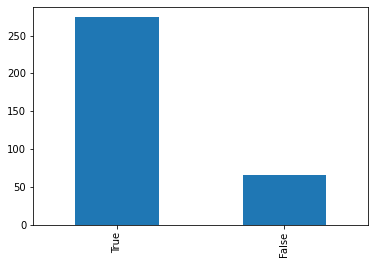

In [9]:
data['Has Bandstructure'].value_counts().plot(kind='bar')

2 unique values, True and False. Classic example of when to use one-hot encoding

In [10]:
# One-hot encode 'Has Bandstructure'
data['Has Bandstructure'] = data['Has Bandstructure'].map({True:1, False:0})

### `'Spacegroup'` column

44


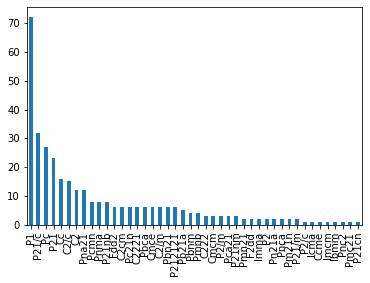

In [11]:
data['Spacegroup'].value_counts().plot(kind='bar')
print(data['Spacegroup'].nunique())

44 unique values, with most of them occuring multiple times

**Option 1:** One-hot encoding will result in 44 new feature columns; inefficient and memory-intensive.

**Option 2:** Encode to ordinal numbers. Will possibly work, but does leave a residual structure that may affect model performance

**Option 3:** Use Feature Hashing to create a vector representation of each unique Spacegroup. Note that if vector size = 44, it's the same as one-hot encoding, and if vector size = 1, it's the same as encoding to ordinal variables. Use vector size = 3 for this

In [12]:
# Option 1: One-hot encoding (not used)
pd.get_dummies(data['Spacegroup'])

,C2,C2/c,C2/m,C222,C2221,C2cm,Cc,Ccme,Cmce,Cmcm,...,Pcmn,Pm21n,Pmc21,Pmn21,Pmnb,Pn21a,Pna21,Pnc2,Pnca,Pnma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Option 2: Ordinal number encoding
data['Spacegroup (ordinal)'] = pd.factorize(data['Spacegroup'])[0]

# Can also order by most common to least common
data['Spacegroup'].rank(method="dense").astype(int)

0      32
1      22
2       7
3       2
4       2
       ..
334    17
335    17
336    17
337    17
338    17
Name: Spacegroup, Length: 339, dtype: int32

In [14]:
# Option 3: Feature Hashing
n = 3
fh = FeatureHasher(n_features=n, input_type='string')
hashed_tag = fh.fit_transform(data['Spacegroup']).toarray()
ht_df = pd.DataFrame(hashed_tag)
ht_df.columns = ['Spacegroup'+str(i) for i in range(n)]

data = data.join(ht_df)

For now, keep both sets of new features, and we'll see which one performs better

### `'Formula'` column

In [15]:
data['Formula'].value_counts()

LiFeSiO4         42
LiCoSiO4         29
Li2FeSiO4        15
Li2CoSiO4        14
LiMnSiO4         12
                 ..
LiMnSi3O8         1
Li3CoSiO5         1
Li2Co2SiO6        1
Li15Mn15SiO32     1
Li7Fe3(SiO6)2     1
Name: Formula, Length: 114, dtype: int64

114 unique values, most only occuring once. One-hot encoding is out of the question

**Option 1,2,3:** one-hot encoding, ordinal number encoding, and feature hashing all become inefficient with such variety.

**Option 4:** Use domain knowledge to create additional features. For example, we can look at the LiFeSiO4 formula, and turn it into 4 new columns, each one indicating how many of each atom are in the formula (for example, {Li: 1, Fe: 1, Si: 1, O: 4})

In [16]:
# Option 4: use chemparse package to create the new features of atom counts
chem_data = data['Formula'].apply(chemparse.parse_formula)

# Convert the dictionary into a dataframe and fill NaN's with zero's
chem_data = pd.json_normalize(chem_data)
chem_data = chem_data.fillna(0)

data = data.join(chem_data)
for x in data.columns:
    print(x)

Formula
Spacegroup
Formation Energy (eV)
E Above Hull (eV)
Band Gap (eV)
Nsites
Density (gm/cc)
Volume
Has Bandstructure
Crystal System
Spacegroup (ordinal)
Spacegroup0
Spacegroup1
Spacegroup2
Li
Mn
Si
O
Fe
Co


In [22]:
data.head()

,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System,...,Li,Mn,Si,O,Fe,Co,Crystal System (#),monoclinic,orthorhombic,triclinic
0,Li2MnSiO4,Pc,-2.699,0.006,3.462,16,2.993,178.513,1,monoclinic,...,2.0,1.0,1.0,4.0,0.0,0.0,0,1,0,0
1,Li2MnSiO4,P21/c,-2.696,0.008,2.879,32,2.926,365.272,1,monoclinic,...,2.0,1.0,1.0,4.0,0.0,0.0,0,1,0,0
2,Li4MnSi2O7,Cc,-2.775,0.012,3.653,28,2.761,301.775,1,monoclinic,...,4.0,1.0,2.0,7.0,0.0,0.0,0,1,0,0
3,Li4Mn2Si3O10,C2/c,-2.783,0.013,3.015,38,2.908,436.183,1,monoclinic,...,4.0,2.0,3.0,10.0,0.0,0.0,0,1,0,0
4,Li2Mn3Si3O10,C2/c,-2.747,0.016,2.578,36,3.334,421.286,1,monoclinic,...,2.0,3.0,3.0,10.0,0.0,0.0,0,1,0,0


### `'Crystal System'` column
This is the target column, and there are 3 different types of crystal structures we're trying to classify. To properly transform this to numerical data, we have to understand if we are working on a multi-class problem or a multi-label problem.

- A multi-class problem is one in which there is only one distinct type of classification for each row. For example, a fruit is either an apple or an orange, but cannot be both. For a multi-class problem, the target value should be a single value, such as a 0 for apple and 1 for orange. In other words, it would be encoded to ordinal numbers.
- A multi-label problem is one in which there are possibly multiple labels for each row. For example, classifying pictures of apples and oranges can include a picture of an apple alone, an orange alone, or both an apple and an orange. For a multi-label problem, the target value should be a vector representation, such as [1,0] for apple, [0,1] for orange, and [1,1] for both apple and orange. In other words, we would have to one-hot encode the target feature.

Since the crystal system structure is unique, this is a multi-class problem. The target output should be encoded to a 0, 1, or 2. If it were a multi-label problem, the target output would have to be encoded to a vector of length 3. 

In [17]:
# Encode Crystal System to ordinal values for multi-class problem
labelencoder = LabelEncoder() #initializing an object of class LabelEncoder
data['Crystal System (#)'] = labelencoder.fit_transform(data['Crystal System']) 

# For a multi-label problem, use one-hot encoding
data[['monoclinic','orthorhombic','triclinic']] = pd.get_dummies(data['Crystal System'])

<AxesSubplot:>

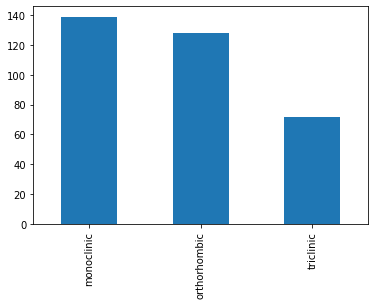

In [18]:
# Check for balance
data['Crystal System'].value_counts().plot(kind='bar')

In [19]:
# Save new features in dataframe
data.to_csv('lithium_ion_data.csv',index=False)

### Test performance

In [20]:
# All new numerical features (Crystal System excluded, since it's int32)
features = list(data.select_dtypes(include=['int64','float64']).columns.values)

ord_feat = ['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
            'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
            'Spacegroup (ordinal)','Li','Mn','Si','O','Fe','Co'
           ]

hash_feat = ['Formation Energy (eV)','E Above Hull (eV)','Band Gap (eV)',
             'Nsites','Density (gm/cc)','Volume','Has Bandstructure',
             'Spacegroup0','Spacegroup1','Spacegroup2',
             'Li','Mn','Si','O','Fe','Co'
            ]

labels = ['Crystal System (#)']

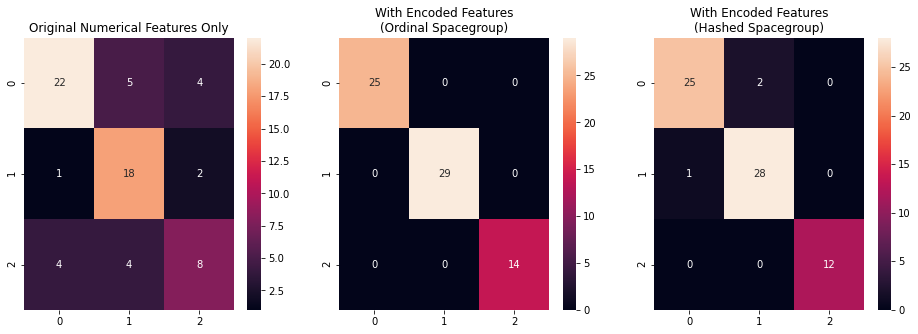

In [21]:
plt.figure(figsize=(16,5))

titles = ['Original Numerical Features Only',
          'With Encoded Features\n(Ordinal Spacegroup)',
          'With Encoded Features\n(Hashed Spacegroup)'
         ]

for i, feat in enumerate([num_feat,ord_feat,hash_feat]):
    X = data[feat]
    y = data[labels]

    # 80% training data and 20% testing
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

    dtree = DecisionTreeClassifier()
    dtree.fit(Xtrain,ytrain)
    yp = dtree.predict(Xtest)
    
    # Plot confusion matrix
    plt.subplot(1,3,i+1)
    cm = confusion_matrix(ytest,yp)
    sns.heatmap(cm,annot=True)
    plt.title(titles[i])